In [1]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib
import tensorflow as tf
import tensorflow.keras as K
import math, datetime, pandas as pd, numpy as np
import matplotlib.pyplot as plt,random, pickle, glob, os
import sklearn
from PIL import Image
import tarfile
import cv2
import random

## Loading data

Download and extract training data by uncommenting below cell

In [2]:
# !wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
# fname='imagenet-sample-train.tar.gz'
# if (fname.endswith("tar.gz")):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [2]:
input_size=64

In [3]:
# path='train/'

# img_list = glob.glob(path+'**/*.JPEG', recursive=True)
# n = len(img_list); n

In [4]:
train_df=pd.read_csv('train_data.csv')
train_df.shape

(2152, 3)

In [5]:
train_list=train_df.ids
len(train_list)

2152

In [6]:
val_list = glob.glob('set5/*.*', recursive=True)
len(val_list)

5

In [9]:
def read_image(img_path):
    global input_size
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lr = cv2.resize(img, (input_size,input_size),interpolation=cv2.INTER_CUBIC)
    img_hr = cv2.resize(img, (input_size*4,input_size*4),interpolation=cv2.INTER_CUBIC)
    return img_lr,img_hr


(256, 256, 3)


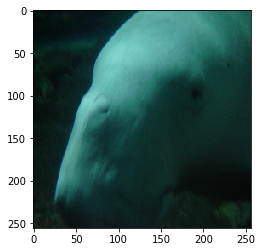

In [10]:
_,img=read_image(train_list[3])
print(img.shape)
plt.imshow(img)

(256, 256, 3)


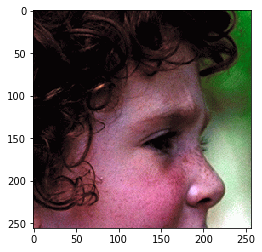

In [11]:
_,img=read_image(val_list[0])
print(img.shape)
plt.imshow(img)

## Super Resolution Model

In [12]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [13]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [14]:
# def deconv_block(x, filters,size, shape, stride=(1,1)):
#     x = K.layers.Convolution2DTranspose(filters, size, size, strides=stride, 
#        padding='same', output_shape=(None,)+shape)(x)
#     return K.layers.Activation('relu')(x)

In [15]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [16]:
def get_srmodel():
    inp=K.Input(shape=(None,None,3))

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(3): x=res_block(x,16)

    x=up_block(x,nf=32)
    for i in range(2): x=res_block(x,32)

    x=up_block(x,nf=64)
    for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(16,(3,3),padding='same',activation='relu')(x)
    outp= K.layers.Conv2D(3,(1,1),padding='same',name='output_layer')(x)
    return inp,outp

In [17]:
inp,outp=get_srmodel()
sr_model=K.Model(inp,outp)
sr_model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                (None, None, None, 3)   0                                                 
______________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, None, None, 16)  448          input_1[0][0]                        
______________________________________________________________________________________________________________
activation (Activation)             (None, None, None, 16)  0            conv2d[0][0]                         
______________________________________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, None, None, 16)  2320         activation[0][0]                     
_

### loading vgg for calculating perceptual loss from one of its layer

In [18]:
vgg_inp=K.Input(shape=outp.shape[1:])
vgg= K.applications.VGG16(include_top=False, 
                                  input_tensor=vgg_inp)

In [19]:
for l in vgg.layers: l.trainable=False

In [61]:
# preproc_layer = K.layers.Lambda(preproc)

In [20]:
#Here we are using vgg layer at index 36 to be the layer to calculate loss between Traget and predicted image
vgg_out_layer = vgg.get_layer(index=5).output

# making model Model(inputs, outputs)
vgg_content = K.Model(vgg_inp, vgg_out_layer)

vgg_content.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_2 (InputLayer)                             (None, None, None, 3)                       0                
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)                      1792             
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, None, 64)                      36928            
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)                       (None, None, None, 64)                      0                
_

## Data Generator and Metrics

In [28]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img

In [29]:
def randomCrop(img):
    global input_size
    h=input_size*4
    assert img.shape[0] >= h
    assert img.shape[1] >= h
    x = random.randint(0, img.shape[1] - h)
    y = random.randint(0, img.shape[0] - h)
    img = img[y:y+h, x:x+h]
    return img

In [21]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = randomCrop(img)
                tar = randomHorizontalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*4, input_size*4),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [66]:
# l=next(valid_generator())

In [22]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [23]:
# This is our perceptual loss function
def perceptual_loss(y_true,y_pred):
    y_t=vgg_content(y_true)
    y_p=vgg_content(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [24]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
sr_model.compile(optimizer=adam,loss=perceptual_loss,metrics=[psnr,ssim])

In [25]:
batch_size=16
input_size=64

In [26]:
def fit(model,epoch=2):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [30]:
sr_model=fit(sr_model,10)

Epoch 1/10
135/135 [==============================] - 111s 825ms/step - loss: 8.8343 - psnr: 17.9194 - ssim: 0.5260 - val_loss: 6.4367 - val_psnr: 19.5382 - val_ssim: 0.6075
Epoch 2/10
135/135 [==============================] - 103s 764ms/step - loss: 7.6767 - psnr: 20.2559 - ssim: 0.5599 - val_loss: 6.1113 - val_psnr: 18.8636 - val_ssim: 0.6203
Epoch 3/10
135/135 [==============================] - 103s 765ms/step - loss: 7.4465 - psnr: 20.5503 - ssim: 0.5683 - val_loss: 5.6222 - val_psnr: 20.4527 - val_ssim: 0.6418
Epoch 4/10
135/135 [==============================] - 103s 765ms/step - loss: 7.2672 - psnr: 20.8844 - ssim: 0.5750 - val_loss: 5.5254 - val_psnr: 20.3579 - val_ssim: 0.6403
Epoch 5/10
135/135 [==============================] - 103s 766ms/step - loss: 7.2620 - psnr: 20.8982 - ssim: 0.5753 - val_loss: 5.5685 - val_psnr: 20.2058 - val_ssim: 0.6392
Epoch 6/10
135/135 [==============================] - 103s 766ms/step - loss: 7.1848 - psnr: 20.8494 - ssim: 0.5773 - val_loss: 5.

In [34]:
sr_model=fit(sr_model,10)

Epoch 1/10
135/135 [==============================] - 102s 759ms/step - loss: 7.0184 - psnr: 21.0164 - ssim: 0.5801 - val_loss: 5.0490 - val_psnr: 21.8191 - val_ssim: 0.6553
Epoch 2/10
135/135 [==============================] - 103s 764ms/step - loss: 6.9212 - psnr: 21.2193 - ssim: 0.5824 - val_loss: 5.0385 - val_psnr: 21.9772 - val_ssim: 0.6502
Epoch 3/10
135/135 [==============================] - 103s 766ms/step - loss: 6.9286 - psnr: 21.2250 - ssim: 0.5821 - val_loss: 4.9341 - val_psnr: 22.3117 - val_ssim: 0.6580
Epoch 4/10
135/135 [==============================] - 104s 767ms/step - loss: 6.9402 - psnr: 21.1410 - ssim: 0.5783 - val_loss: 4.8855 - val_psnr: 21.7688 - val_ssim: 0.6536
Epoch 5/10
135/135 [==============================] - 104s 767ms/step - loss: 6.9130 - psnr: 21.2003 - ssim: 0.5788 - val_loss: 5.0059 - val_psnr: 20.7628 - val_ssim: 0.6491
Epoch 6/10
135/135 [==============================] - 104s 767ms/step - loss: 6.8893 - psnr: 21.2016 - ssim: 0.5771 - val_loss: 4.

In [35]:
tlr,hlr=read_image(val_list[2])
tlr=np.expand_dims(tlr,axis=0)
pred=sr_model.predict(tlr/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


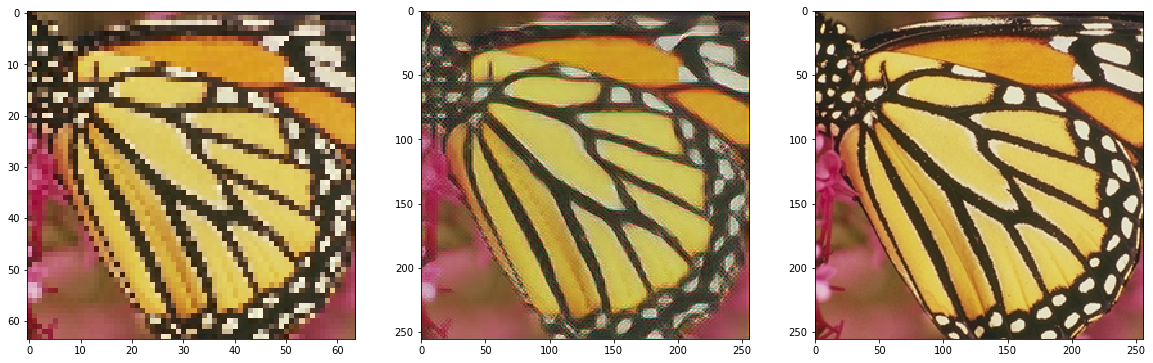

In [36]:
_,axs=plt.subplots(1,3,figsize=(20,20))
ax=axs.flat
ax[0].imshow(tlr[0]/255.)
ax[1].imshow(pred[0])
ax[2].imshow(hlr/255.)

In [37]:
K.models.save_model(sr_model,'sr_final.h5',include_optimizer=False)